#CEIA - IIA - TP2: Regresión del valor de valor medio de casas en distritos de California (20Co2025)

## Grupo 1 - 
### Miembros:
- Martín Brocca <martinbrocca@gmail.com>
- Emiliano Iparraguirre <emiliano.iparraguirre22@gmail.com>
- Natalia Espector <nataliaespector@gmail.com>
- Agustín Lopez Fredes <agustin.lopezfredes@gmail.com>
- Fernando Martinez <fgmartinez1989@gmail.com>

### Tareas y preguntas a resolver:

1. Obtener la correlación entre los atributos y entre los atributos y el target. ¿Qué atributo tiene mayor correlación lineal con el target? ¿Cuáles atributos parecen estar más correlacionados entre sí? Se pueden obtener los valores de correlación o graficarlos directamente utilizando un mapa de calor.
2. Graficar los histogramas de los diferentes atributos y el target. ¿Qué tipo de forma tienen los histogramas? ¿Se observa alguna forma de campana que sugiera que los datos provienen de una distribución gaussiana, sin realizar pruebas de hipótesis?
3. Calcular la regresión lineal utilizando todos los atributos. Con el conjunto de entrenamiento, calcular la varianza total del modelo y la varianza explicada por el modelo. ¿Está el modelo capturando el comportamiento del target? Expanda su respuesta.
4. Calcular las métricas de MSE, MAE y R² para el conjunto de evaluación.
5. Crear una regresión de Ridge. Usando validación cruzada de 5 folds y tomando como métrica el MSE, calcular el mejor valor de α, buscando entre [0, 12.5]. Graficar el valor de MSE versus α.
6. Comparar entre la regresión lineal y la mejor regresión de Ridge los resultados obtenidos en el conjunto de evaluación. ¿Cuál de los dos modelos da mejores resultados (usando MSE y MAE)? Conjeturar por qué el modelo que da mejores resultados mejora. ¿Qué error se puede haber reducido?


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge

sns.set()

In [5]:
# comprobar que el dataset se cargó correctamente:
california_housing = fetch_california_housing()
display(california_housing)

{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ...,
        [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
           39.43      , -121.22      ],
        [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
           39.43      , -121.32      ],
        [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
           39.37      , -121.24      ]], shape=(20640, 8)),
 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894], shape=(20640,)),
 'frame': None,
 'target_names': ['MedHouseVal'],
 'feature_names': ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 'DESCR': 

In [17]:
#separamos la data del target:
x = california_housing.data
y = california_housing.target

In [18]:

# Pasar a Pandas para el manejo
x = pd.DataFrame(x, columns=california_housing['feature_names'])
y = pd.Series(y, name=california_housing['target_names'][0])

df_california = pd.concat([x, y], axis=1)

In [19]:
# leer el dataset
x.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [20]:
# leer el dataset
y.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

In [21]:
df_california.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [32]:
df_california.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [22]:
#verifico si hay nulls:
df_california.isnull().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

1. Obtener la correlación entre los atributos y entre los atributos y el target. ¿Qué atributo tiene mayor correlación lineal con el target? ¿Cuáles atributos parecen estar más correlacionados entre sí? Se pueden obtener los valores de correlación o graficarlos directamente utilizando un mapa de calor.

In [26]:
#Analicemos la correlaccion mediante Pandas
correlation_matrix = df_california.corr()
correlation_matrix

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176,0.688075
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197,0.105623
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540,0.151948
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344,-0.046701
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773,-0.024650
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476,-0.023737
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664,-0.144160
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000,-0.045967
MedHouseVal,0.688075,0.105623,0.151948,-0.046701,-0.024650,-0.023737,-0.144160,-0.045967,1.000000


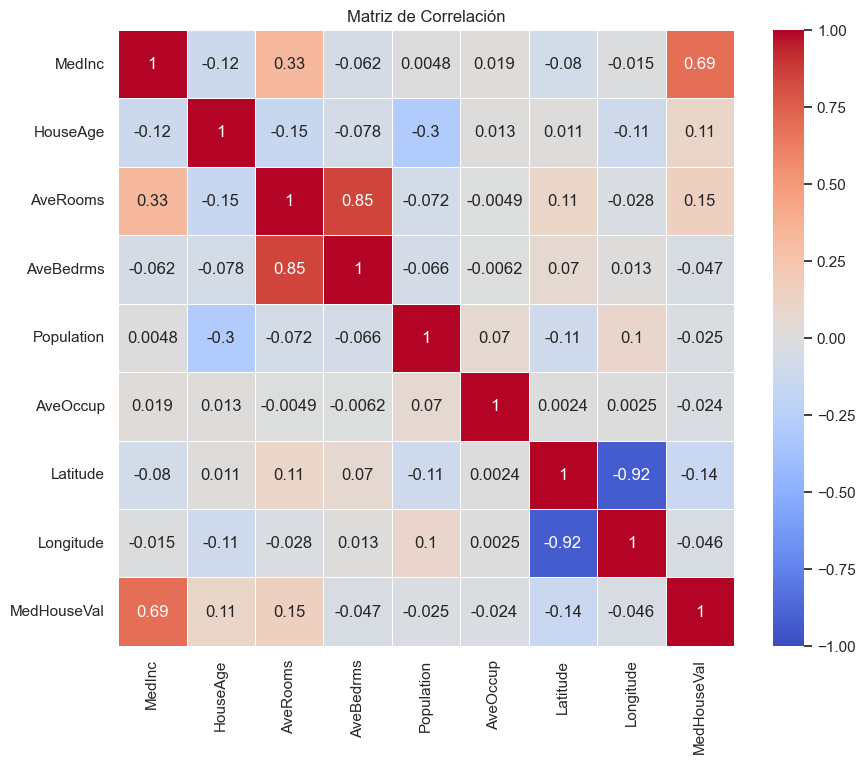

In [27]:
# Crear el heatmap
plt.figure(figsize=(10, 8))  
sns.heatmap(correlation_matrix, 
            annot=True,  
            cmap='coolwarm',  
            vmin=-1, vmax=1,  
            center=0,  
            square=True,  
            linewidths=0.5)  
plt.title('Matriz de Correlación')  
plt.show()

El atributo MedInc es el de mayor valor con Med HouseVal, lo que podría indicar una correlación entre atributos.
El número de habitaciones tiene una correlación con la cantidad de dormitorios.


2. Graficar los histogramas de los diferentes atributos y el target. ¿Qué tipo de forma tienen los histogramas? ¿Se observa alguna forma de campana que sugiera que los datos provienen de una distribución gaussiana, sin realizar pruebas de hipótesis?

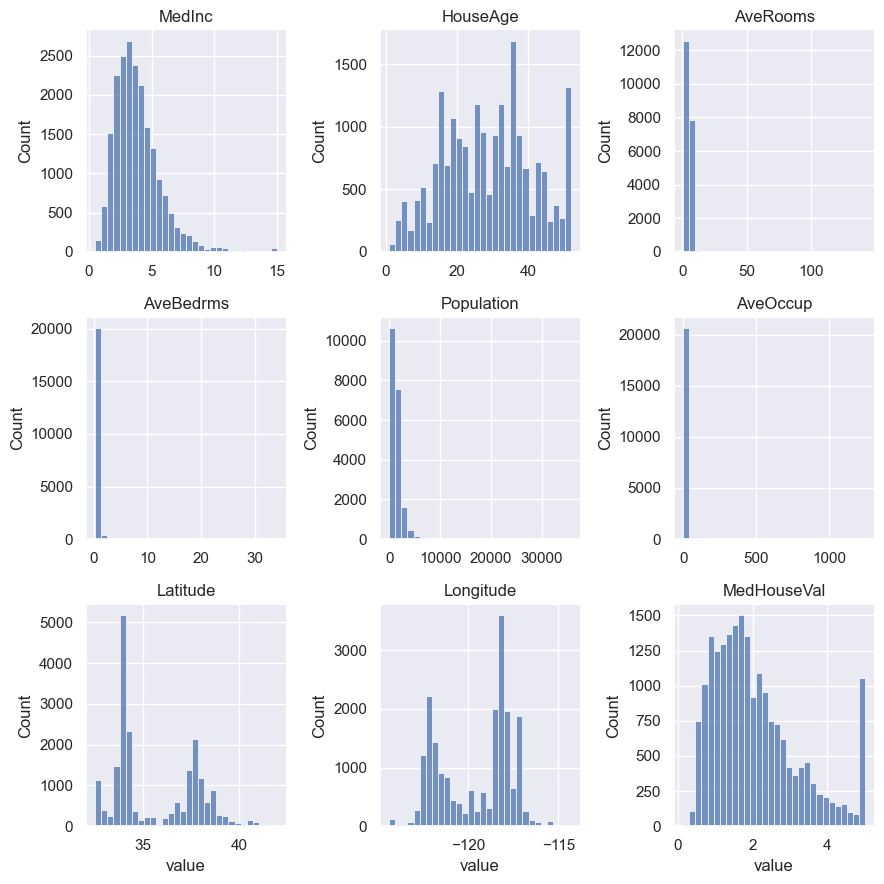

In [28]:
df_melted = df_california.melt()  # Convierte el DataFrame a formato largo
g = sns.FacetGrid(df_melted, col="variable", col_wrap=3, height=3, sharex=False, sharey=False)
g.map(sns.histplot, "value", bins=30)
g.set_titles("{col_name}")  # Usa el nombre de la columna como título
plt.tight_layout()
plt.show()

In [33]:
df_california.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


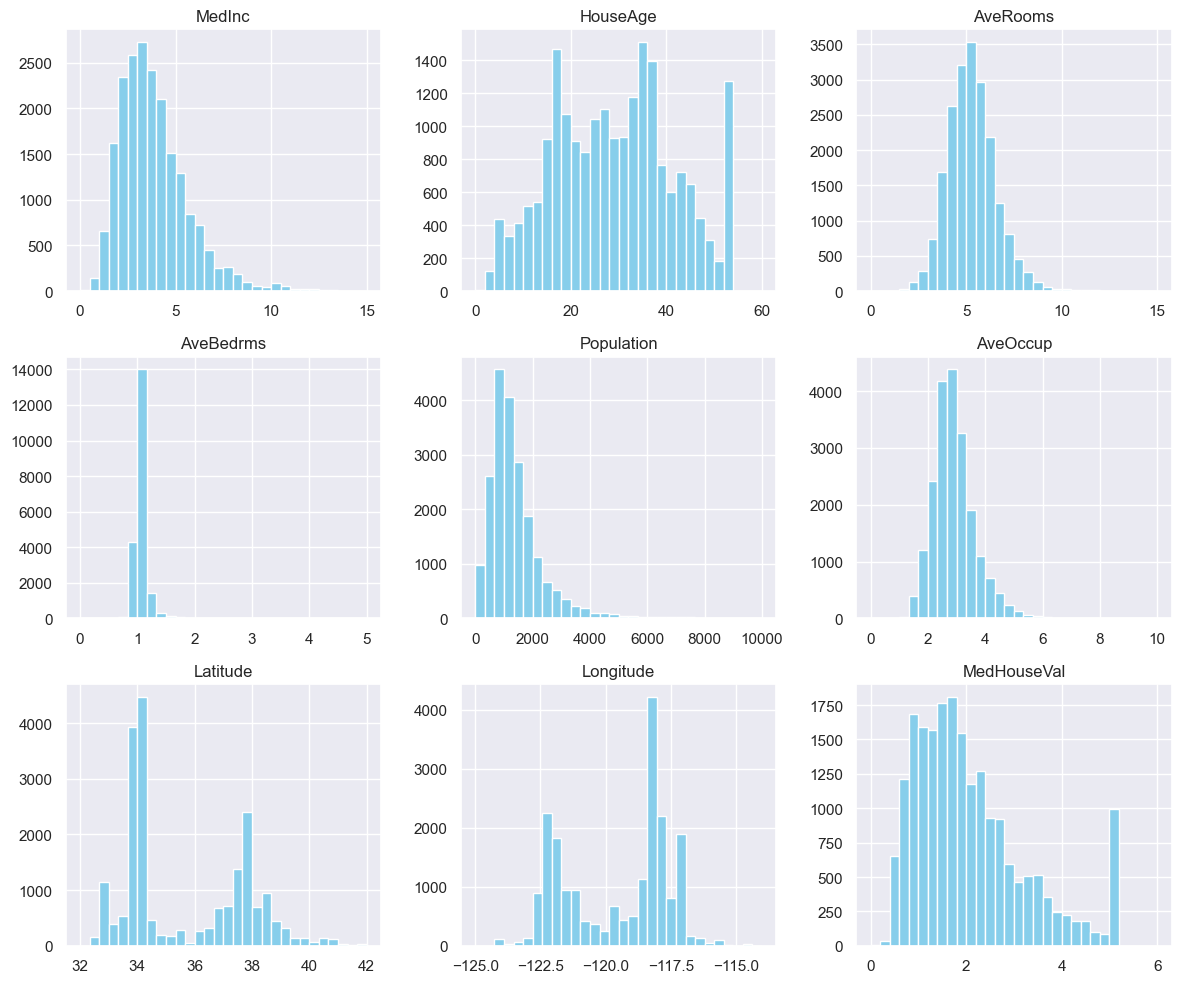

In [ ]:
# En esta version de los histogramas corrijo los rangos de cada variable para que no pase lo que se en el grafico de las habitaciones 

fig, axes = plt.subplots(3, 3, figsize=(12, 10))  # 3x3 para 9 columnas
axes = axes.flatten()  # Convierte la matriz de ejes en una lista plana

# Rangos personalizados para cada columna 
ranges = {
    'MedInc': (0, 15),        # Ingreso medio
    'HouseAge': (0, 60),      # Edad de casas
    'AveRooms': (0, 15),      # Habitaciones (limitamos outliers)
    'AveBedrms': (0, 5),      # Dormitorios (limitamos outliers)
    'Population': (0, 10000),  # Población 
    'AveOccup': (0, 10),      # Ocupantes por hogar
    'Latitude': (32, 42),     # Latitud de California
    'Longitude': (-125, -114),# Longitud de California
    'MedHouseVal': (0, 6)     # Valor medio en $100k
}

# Crear histogramas con rangos personalizados
for i, col in enumerate(df_california.columns):
    df_california[col].hist(bins=30, range=ranges[col], ax=axes[i], color='skyblue')
    axes[i].set_title(col)
    axes[i].set_xlabel('')  # Opcional: quita etiquetas de ejes si prefieres

plt.tight_layout()
plt.show()




## Aca hay que poner conclusiones de mirar los graficos

3. Calcular la regresión lineal utilizando todos los atributos. Con el conjunto de entrenamiento, calcular la varianza total del modelo y la varianza explicada por el modelo. ¿Está el modelo capturando el comportamiento del target? Expanda su respuesta.


In [40]:
print(f"X es de tipo: {type(x)}")
print(f"El shape es de 2D: {x.shape}")
x.head()

X es de tipo: <class 'pandas.core.frame.DataFrame'>
El shape es de 2D: (20640, 8)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [41]:
print(f"El label es de tipo: {type(y)}")
print(f"El shape es de 1D: {y.shape}")
y.head()

El label es de tipo: <class 'pandas.core.series.Series'>
El shape es de 1D: (20640,)


0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

In [42]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=99)


In [43]:
print("Valores de X_train:",X_train.size)
print("Valores de y_train:",y_train.size)
print("Valores de X_test:",len(X_test))
print("Valores de y_test:",len(y_test))

Valores de X_train: 115584
Valores de y_train: 14448
Valores de X_test: 6192
Valores de y_test: 6192


In [44]:
regresion = LinearRegression()


In [45]:
regresion


LinearRegression()

In [46]:
regresion.fit(X_train, y_train)


LinearRegression()

In [47]:
print(f"El valor de la intersección de la recta es {round(regresion.intercept_, 3) }")
print(f"El valor del coeficiente de la recta es {np.round(regresion.coef_, 3) }")
print(f"La ecuación de la recta entonces es: y = {np.round(regresion.intercept_, 3) }+({np.round(regresion.coef_[0], 3)})x")

El valor de la intersección de la recta es -37.254
El valor del coeficiente de la recta es [ 0.428  0.01  -0.094  0.565  0.    -0.003 -0.426 -0.439]
La ecuación de la recta entonces es: y = -37.254+(0.428)x


In [48]:
print(f"El coeficiente de Pearson es {round(regresion.score(X_train, y_train), 2)}")


El coeficiente de Pearson es 0.6


In [49]:
y_model = regresion.predict(X_train)


In [50]:
std_dev_model = np.sqrt((np.sum((y_train - y_model)**2))/(y_train.size - 2))
print(f"Desvío estándar del modelo {round(std_dev_model, 3)}")

Desvío estándar del modelo 0.73


## Aca veo si puedo graficar la regresion con los puntos, dejar el que mejor se vea, o sirva

/Users/martin/Library/Caches/pypoetry/virtualenvs/tp1-torreshanoi-w7PjVPuI-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


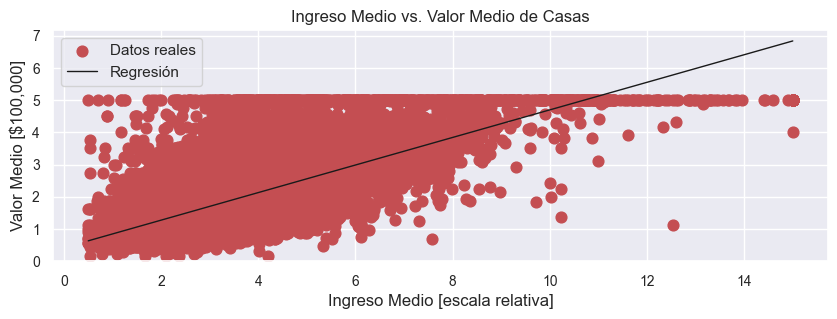

In [59]:
# Seleccionamos solo la columna 'MedInc' (índice 0 si X_train es un DataFrame o array)
# Si X_train es un DataFrame:
x_medinc = X_train['MedInc']
# Si X_train es un array de numpy, usa el índice de la columna (0 para MedInc):
# x_medinc = X_train[:, 0]

# Configuración del gráfico
plt.figure(figsize=(10, 3))
plt.title('Ingreso Medio vs. Valor Medio de Casas', fontsize=12)
plt.xlabel('Ingreso Medio [escala relativa]', fontsize=12)
plt.ylabel('Valor Medio [$100,000]', fontsize=12)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)

# Puntos reales
plt.scatter(x_medinc, y_train, color='r', marker="o", s=60, label='Datos reales')

# Línea de predicción
# Para graficar la recta, necesitamos predecir usando solo MedInc, pero como el modelo usa todas las variables,
# creamos un rango de valores para MedInc y mantenemos las demás constantes (usamos el promedio)
x_range = np.linspace(x_medinc.min(), x_medinc.max(), 100)
X_range = np.zeros((100, X_train.shape[1]))  # Matriz con ceros para las otras columnas
X_range[:, 0] = x_range  # Solo llenamos la columna de MedInc
for i in range(1, X_train.shape[1]):
    X_range[:, i] = X_train.iloc[:, i].mean()  # Promedio de las otras columnas
y_pred = regresion.predict(X_range)

plt.plot(x_range, y_pred, color="k", linewidth=1, label='Regresión')

plt.ylim(0)  # Límite inferior en 0 para el eje y
plt.legend()  # Añade leyenda
plt.show()

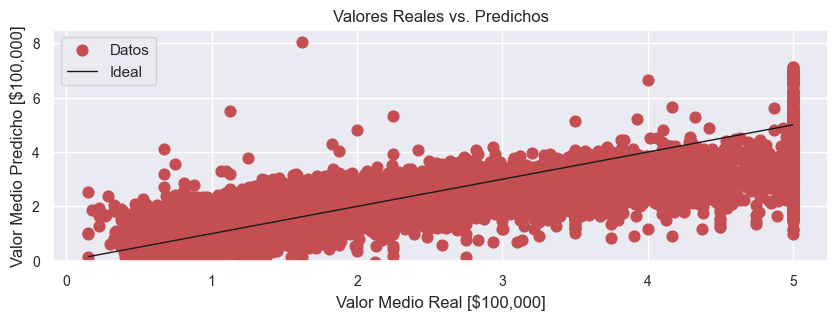

In [58]:


# Configuración del gráfico
plt.figure(figsize=(10, 3))
plt.title('Valores Reales vs. Predichos', fontsize=12)
plt.xlabel('Valor Medio Real [$100,000]', fontsize=12)
plt.ylabel('Valor Medio Predicho [$100,000]', fontsize=12)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)

# Puntos reales vs. predichos
plt.scatter(y_train, y_model, color='r', marker="o", s=60, label='Datos')

# Línea de referencia (y = x, ideal si la predicción fuera perfecta)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color="k", linewidth=1, label='Ideal')

plt.ylim(0)
plt.legend()
plt.show()

# CODIGO Agustin:

In [61]:
# Creamos el pipeline con StandardScaler y regresión lineal
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),       # Escalado estándar
    ('regressor', LinearRegression())   # Modelo de regresión lineal
])

pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [62]:
pipeline.fit(X_train, y_train)
pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [63]:
print(f"El valor de la intersección de la recta es {np.round(pipeline.named_steps['regressor'].intercept_, 2)}")
print(f"Los valores de los coeficientes de la recta son {np.round(pipeline.named_steps['regressor'].coef_, 2)}")

print(f"Las columnas son {x.columns.tolist()}")

El valor de la intersección de la recta es 2.08
Los valores de los coeficientes de la recta son [ 0.82  0.13 -0.25  0.3   0.   -0.04 -0.91 -0.88]
Las columnas son ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


Se observa que la columna MedInc, que arrojaba la mayor correlación, tiene el coeficiente más alto. Resulta llamativo los coeficientes negativos pero de valor absoluto alto de Latitud y Longitud, que en la correlación se había mostrado cerca de 0

Para obtener la varianza total y la varianza explicada por el modelo, usando el conjunto de entrenamiento, parto prediciendo los valores de y

In [64]:
y_pred_train = pipeline.predict(X_train)
y_pred_train

# Varianza total del modelo
sst = np.sum((y_train - np.mean(y_train)) ** 2)

# Varianza no explicada (SSE)
sse = np.sum((y_train - y_pred_train) ** 2)

# Varianza explicada por el modelo (SSR)
ssr = sst - sse

print(f"La varianza total del conjunto de entrenamiento es {sst}")
print(f"La varianza total explicada por el modelo es {ssr}")
print(f"El R2 es {np.round(ssr/sst, 4)}")

La varianza total del conjunto de entrenamiento es 19422.827722867518
La varianza total explicada por el modelo es 11715.314331802132
El R2 es 0.6032


4. Calcular las métricas de MSE, MAE y R² para el conjunto de evaluación.


In [65]:
from sklearn.metrics import (r2_score, mean_absolute_error, 
                             mean_squared_error, root_mean_squared_error, 
                             mean_absolute_percentage_error)

y_pred_test = pipeline.predict(X_test)

r2 = r2_score(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = root_mean_squared_error(y_test, y_pred_test)
mape = mean_absolute_percentage_error(y_test, y_pred_test)

print("R-cuadrado en test:", round(r2, 3))
print("Error absoluto medio:", round(mae, 3))
print("Error cuadrático medio:", round(mse, 3))
print("Raíz de error cuadrático medio:", round(rmse, 3))
print(f"Error absoluto porcentual medio: {mape*100:.2f}%")

R-cuadrado en test: 0.613
Error absoluto medio: 0.521
Error cuadrático medio: 0.504
Raíz de error cuadrático medio: 0.71
Error absoluto porcentual medio: 31.51%


Para comparar con un baseline, utilizamos el promedio de y_train para predecir en el conjunto de test



In [66]:
mean_profit = np.mean(y_train)

y_pred_baseline = np.full_like(y_test, mean_profit)

r2_baseline = r2_score(y_test, y_pred_baseline)
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
mse_baseline = mean_squared_error(y_test, y_pred_baseline)
rmse_baseline = root_mean_squared_error(y_test, y_pred_baseline)
mape_baseline = mean_absolute_percentage_error(y_test, y_pred_baseline)

print("R-cuadrado en test:", round(r2_baseline, 3))
print("Error absoluto medio:", round(mae_baseline, 3))
print("Error cuadrático medio:", round(mse_baseline, 3))
print("Raiz de error cuadrático medio:", round(rmse_baseline, 3))
print(f"Error absoluto porcentual medio: {mape_baseline*100:.2f}%")

R-cuadrado en test: -0.001
Error absoluto medio: 0.907
Error cuadrático medio: 1.302
Raiz de error cuadrático medio: 1.141
Error absoluto porcentual medio: 63.02%


Se observa que el modelo entrenado es superior al base. Por ej la métrica de error porcentual (MAPE) arroja un valor de la mitad respecto al modelo base